In [1]:
import numpy as np
from numpy import median

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

import seaborn as sns

import math

In [2]:
df_train = pd.read_csv("../split_sample/train.csv")
df_val = pd.read_csv("../split_sample/val.csv")

In [3]:
df_train.shape

(5000, 10)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5000 non-null   object 
 1   vendor_id           5000 non-null   int64  
 2   pickup_datetime     5000 non-null   object 
 3   passenger_count     5000 non-null   int64  
 4   pickup_longitude    5000 non-null   float64
 5   pickup_latitude     5000 non-null   float64
 6   dropoff_longitude   5000 non-null   float64
 7   dropoff_latitude    5000 non-null   float64
 8   store_and_fwd_flag  5000 non-null   object 
 9   trip_duration       5000 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 390.8+ KB


In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,5000.0,1.520000,0.499650,1.000000,1.000000,2.000000,2.000000,2.000000
passenger_count,5000.0,1.654400,1.293250,1.000000,1.000000,1.000000,2.000000,6.000000
pickup_longitude,5000.0,-73.973659,0.057585,-74.177292,-73.991638,-73.981895,-73.967855,-70.851616
pickup_latitude,5000.0,40.751530,0.042378,40.619514,40.737639,40.754238,40.768205,43.017578
dropoff_longitude,5000.0,-73.972305,0.056861,-74.183403,-73.991266,-73.979771,-73.962240,-70.851616
dropoff_latitude,5000.0,40.752438,0.045901,40.575306,40.735735,40.754862,40.770319,43.017578
trip_duration,5000.0,969.608200,3616.929016,2.000000,392.000000,656.000000,1066.000000,86329.000000


## Outlier analysis

In [6]:
df_train.select_dtypes(include=[np.number]).skew()

vendor_id            -0.080088
passenger_count       2.131779
pickup_longitude     32.793836
pickup_latitude      30.292904
dropoff_longitude    33.783387
dropoff_latitude     23.922185
trip_duration        22.512101
dtype: float64

In [7]:
def outlier_removal(features):
    global df_train
    for feature in features:
        Q1 = df_train[feature].quantile(0.25)
        Q3 = df_train[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_train = df_train[(df_train[feature] >= lower_bound) & (df_train[feature] <= upper_bound)]

In [8]:
features = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration']
outlier_removal(features)

df_train.select_dtypes(include=[np.number]).skew()

vendor_id           -0.075679
passenger_count      2.138893
pickup_longitude     0.223344
pickup_latitude     -0.057717
dropoff_longitude    0.344331
dropoff_latitude    -0.032798
trip_duration        0.720475
dtype: float64

## Log transformation for trip duration

In [9]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)


df_train.drop(columns='trip_duration',inplace=True)

## Changing Pickup_datetime from object to datetime

**To be able to extract features from it**

In [10]:
df_train['pickup_datetime'] = df_train['pickup_datetime'].astype('datetime64[ns]')

## Change Passenger count from int to object as it contain discrete values

In [11]:
df_train['passenger_count'].unique()

array([1, 2, 3, 6, 5, 4])

In [12]:
df_train['passenger_count'] = df_train['passenger_count'].astype('object')

## Remove useless features such as id, vendor_id

In [13]:
df_train.drop(columns=['id','vendor_id'], inplace=True)

## Saving numerical and categorical and date features columns names

In [14]:
numerical_features = df_train.select_dtypes(exclude=['object','datetime64[ns]']).columns
categorical_features = df_train.select_dtypes(include=['object']).columns
date_features = df_train.select_dtypes(include=['datetime64[ns]']).columns

In [15]:
for category in categorical_features:
    print(f"Category: {category}-------------------------")
    print(df_train[category].unique())

Category: passenger_count-------------------------
[1 2 3 6 5 4]
Category: store_and_fwd_flag-------------------------
['N' 'Y']


## We take numerical and categorical features and analyze the highly correlated features with our target feature (Trip duration).

**Lets start with numerical features**

We'll have a look at the correlation between all the features with the help of Heatmap.

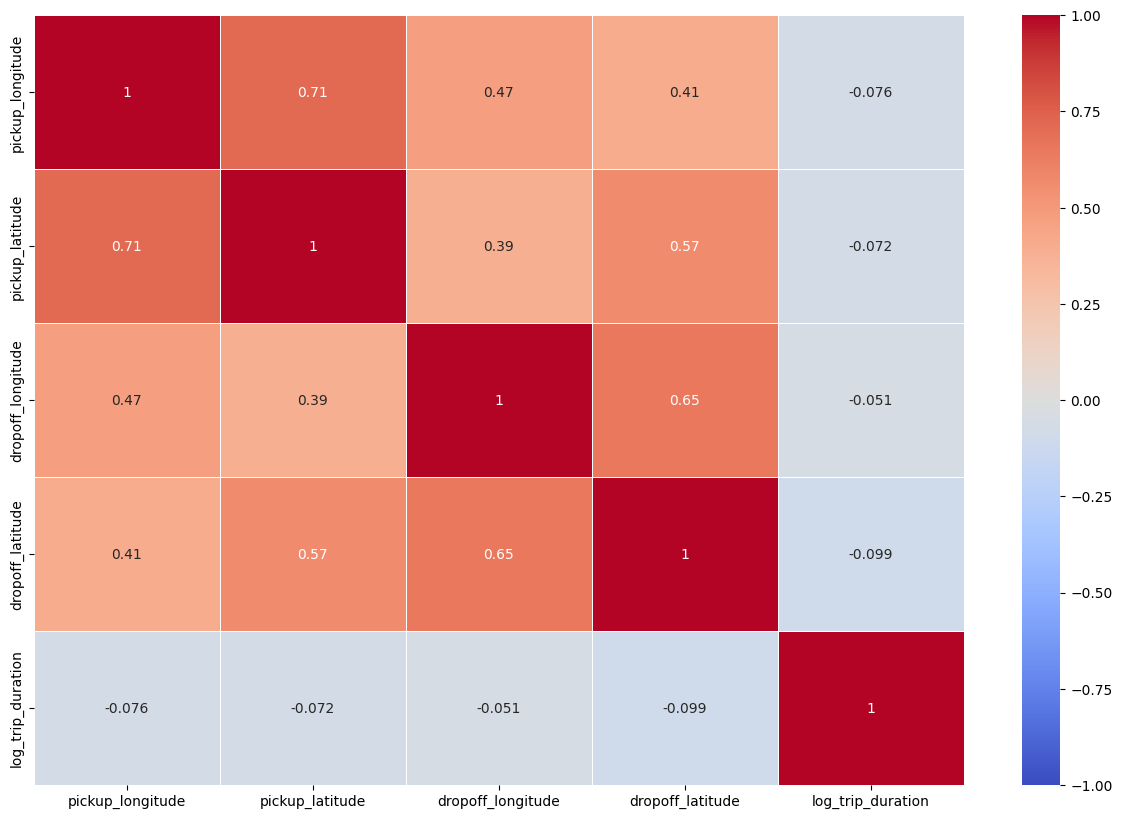

In [16]:
df_corr = df_train[numerical_features]
corr = df_corr.corr()

fig = plt.figure(figsize=(15,10))

sns.heatmap(corr,annot=True,linewidths=.5,cmap='coolwarm',vmin=-1,vmax=1,center=0);

**We conclude that they are low correlated with trip duration lets add new feature as distance between pickup and dropoff**

In [17]:
def deg2rad(deg):
    return np.deg2rad(deg)

def getDistanceFromLatLonInM(lat1, lon1, lat2, lon2):
    R = 6371000.0  # Earth radius in meters
    
    dLat = deg2rad(lat2 - lat1)
    dLon = deg2rad(lon2 - lon1)
    
    a = np.sin(dLat / 2) ** 2 + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dLon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

In [18]:
lat1 = df_train['pickup_latitude'].to_numpy()
lon1 = df_train['pickup_longitude'].to_numpy()
lat2 = df_train['dropoff_latitude'].to_numpy()
lon2 = df_train['dropoff_longitude'].to_numpy()


distance = getDistanceFromLatLonInM(lat1, lon1, lat2, lon2)

df_train = df_train.assign(
    Distance = np.sqrt(distance)
)

log_trip_duration = df_train.pop('log_trip_duration')
df_train['log_trip_duration'] = log_trip_duration

#Update the numerical features
numerical_features = df_train.select_dtypes(exclude=['object','datetime64[ns]']).columns

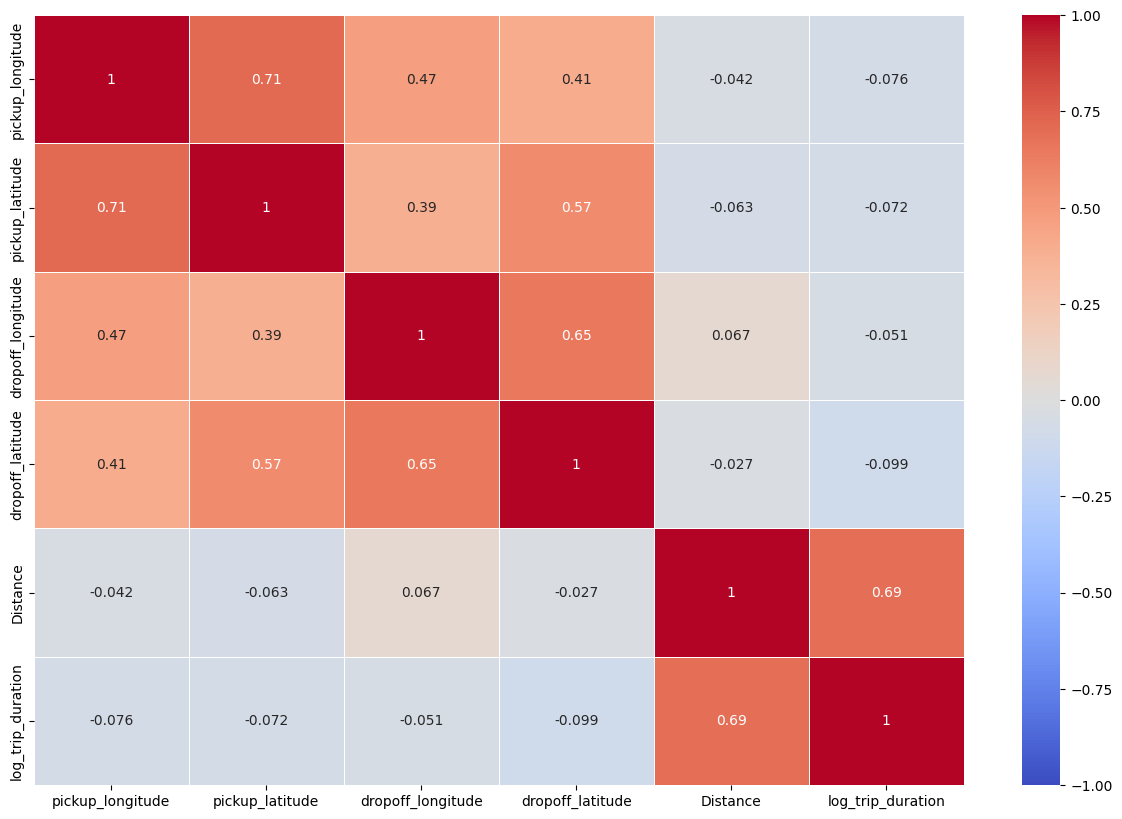

In [19]:
df_corr = df_train[numerical_features]
corr = df_corr.corr()

fig = plt.figure(figsize=(15,10))

sns.heatmap(corr,annot=True,linewidths=.5,cmap='coolwarm',vmin=-1,vmax=1,center=0);

**Much better now lets remove useless features**

In [20]:
df_train.drop(columns=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],inplace = True)

## Categorical Analysis

C:\Users\mosta\AppData\Local\Temp\ipykernel_14524\2465149801.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x="passenger_count", y="log_trip_duration", estimator=median, palette='hot')
C:\Users\mosta\AppData\Local\Temp\ipykernel_14524\2465149801.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x="store_and_fwd_flag", y="log_trip_duration", estimator=median, palette='magma')


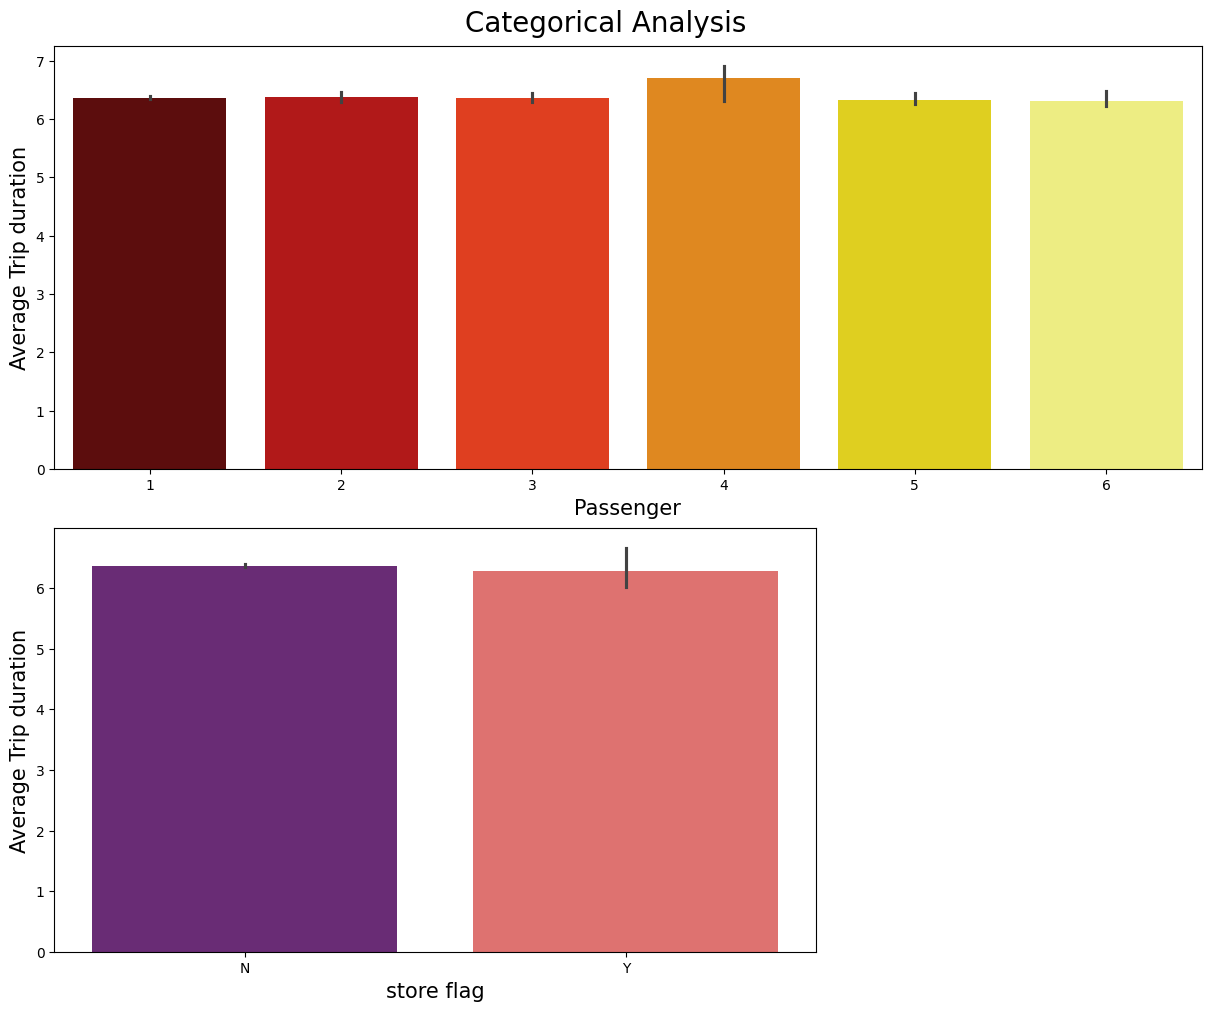

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(12, 10))
gs = GridSpec(2, 3, figure=fig)

plt.subplot(gs[0, :])
sns.barplot(data=df_train, x="passenger_count", y="log_trip_duration", estimator=median, palette='hot')
plt.xlabel("Passenger", fontsize=15)
plt.ylabel("Average Trip duration", fontsize=15)

plt.subplot(gs[1, :-1])
sns.barplot(data=df_train, x="store_and_fwd_flag", y="log_trip_duration", estimator=median, palette='magma')
plt.xlabel("store flag", fontsize=15)
plt.ylabel("Average Trip duration", fontsize=15)

plt.suptitle("Categorical Analysis", fontsize=20);

**Here we see That both of these categorical features important in predicting trip duration**

## Datetime features

In [22]:
months = df_train['pickup_datetime'].dt.month.astype(int)
day_of_week = df_train['pickup_datetime'].dt.day_of_week.astype(int)
day_of_year = df_train['pickup_datetime'].dt.day_of_year.astype(int)
hours = df_train['pickup_datetime'].dt.hour.astype(int)

df_train = df_train.assign(
    months = months,
    day_of_week = day_of_week,
    day_of_year = day_of_year,
    hours = hours
)

datetime_features = ['months','day_of_week','day_of_year','hours']

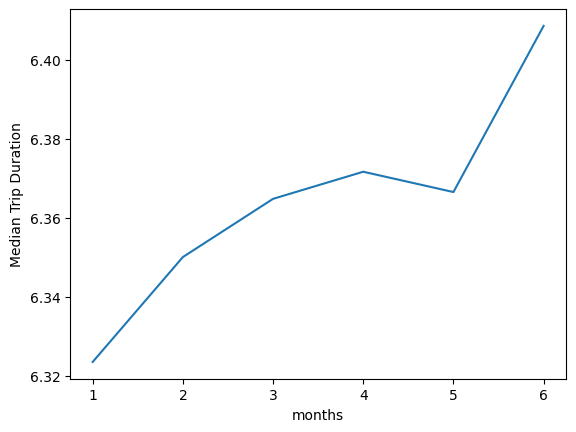

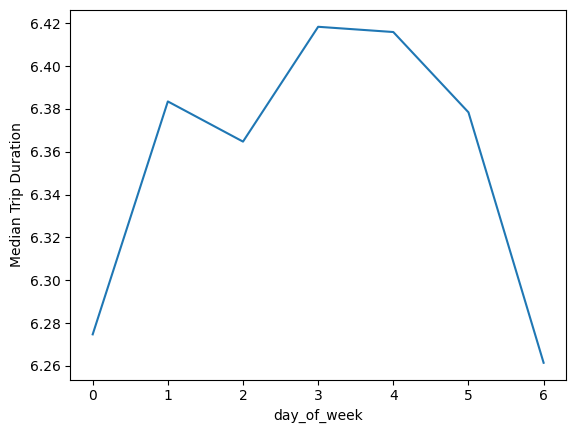

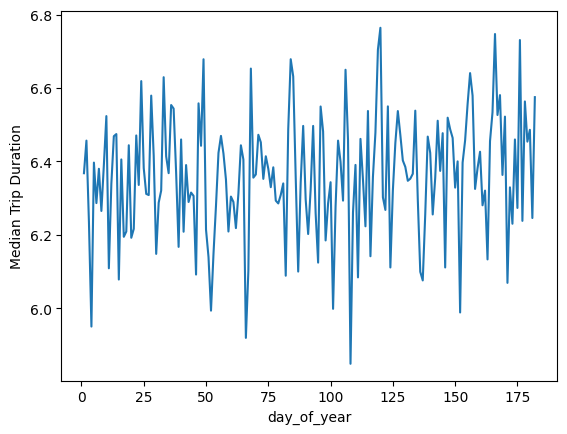

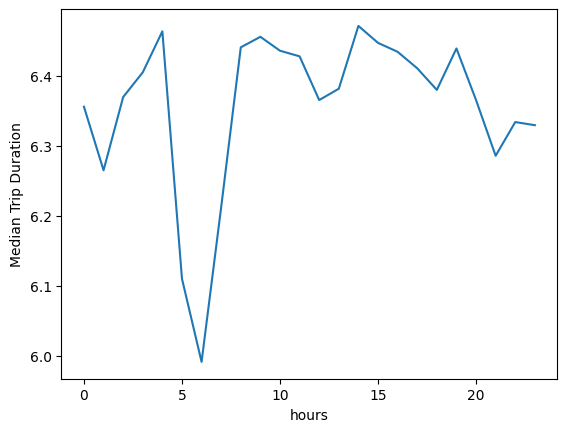

In [23]:
for feature in datetime_features:
    ax = df_train.groupby([feature])['log_trip_duration'].median().plot()
    plt.ylabel("Median Trip Duration")
    plt.show()

**All date time features are good except day_of_year which is misleading for our model so lets remove it**

In [24]:
df_train.drop(columns='day_of_year',inplace = True)

log_trip_duration = df_train.pop('log_trip_duration')
df_train['log_trip_duration'] = log_trip_duration

In [25]:
df_train.duplicated().sum()

np.int64(0)

In [26]:
df_train = df_train.drop_duplicates(keep="last")

In [27]:
df_train.shape

(4180, 8)

In [28]:
df_train.head()

,pickup_datetime,passenger_count,store_and_fwd_flag,Distance,months,day_of_week,hours,log_trip_duration
0,2016-01-08 22:31:12,1,N,50.847065,1,4,22,6.265301
1,2016-01-02 12:36:39,1,N,46.861374,1,5,12,6.684612
2,2016-02-21 00:24:16,1,N,33.007901,2,6,0,5.926926
3,2016-05-08 15:06:34,1,N,53.871014,5,6,15,6.546785
4,2016-05-06 13:54:36,2,N,45.988252,5,4,13,6.556778


# Exploratory Data Analysis (EDA) Summary

## Steps Performed

1. **Data Loading and Initial Inspection**
   - Loaded the training dataset using pandas.
   - Inspected the shape, info, and descriptive statistics of the data.

2. **Outlier Analysis and Removal**
   - Checked skewness of numerical features.
   - Defined and applied an outlier removal function using the IQR method for key numerical columns (`pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, `trip_duration`).

3. **Log Transformation**
   - Applied a log transformation to the `trip_duration` column to reduce skewness and improve normality.
   - Dropped the original `trip_duration` column.

4. **Datetime Feature Engineering**
   - Converted `pickup_datetime` from object to datetime type for feature extraction.

5. **Categorical Feature Handling**
   - Converted `passenger_count` from integer to object type, recognizing it as a categorical variable.
   - Dropped non-informative columns (`id`, `vendor_id`).

6. **Feature Categorization**
   - Saved lists of numerical, categorical, and datetime feature names for further analysis.

7. **Correlation Analysis**
   - Plotted a heatmap of correlations among numerical features.
   - Observed low correlation between original features and trip duration.

8. **Distance Feature Engineering**
   - Engineered a new `Distance` feature using the Haversine formula to calculate the distance between pickup and dropoff points.
   - Updated the list of numerical features and re-plotted the correlation heatmap, observing improved correlation with trip duration.

9. **Feature Reduction**
   - Dropped latitude and longitude columns after creating the `Distance` feature.

10. **Categorical Analysis**
    - Visualized the relationship between categorical features (`passenger_count`, `store_and_fwd_flag`) and log-transformed trip duration using bar plots.

11. **Datetime Feature Analysis**
    - Extracted new datetime features: `months`, `day_of_week`, `day_of_year`, and `hours`.
    - Visualized the effect of these features on median trip duration.
    - Determined that `day_of_year` was not useful and removed it.